Deep Learning
=============

Assignment 3
------------

Previously in `2_fullyconnected.ipynb`, you trained a logistic regression and a neural network model.

The goal of this assignment is to explore regularization techniques.

In [1]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
from __future__ import print_function
import numpy as np
import tensorflow as tf
from six.moves import cPickle as pickle
import matplotlib.pyplot as plt
%matplotlib inline

First reload the data we generated in _notmist.ipynb_.

In [2]:
pickle_file = '/Users/darshanbagul/Documents/UB studies/Deep Learning/Udacity/Assignment1/notMNIST.pickle'

with open(pickle_file, 'rb') as f:
  save = pickle.load(f)
  train_dataset = save['train_dataset']
  train_labels = save['train_labels']
  valid_dataset = save['valid_dataset']
  valid_labels = save['valid_labels']
  test_dataset = save['test_dataset']
  test_labels = save['test_labels']
  del save  # hint to help gc free up memory
  print('Training set', train_dataset.shape, train_labels.shape)
  print('Validation set', valid_dataset.shape, valid_labels.shape)
  print('Test set', test_dataset.shape, test_labels.shape)

Training set (200000, 28, 28) (200000,)
Validation set (10000, 28, 28) (10000,)
Test set (10000, 28, 28) (10000,)


Reformat into a shape that's more adapted to the models we're going to train:
- data as a flat matrix,
- labels as float 1-hot encodings.

In [3]:
image_size = 28
num_labels = 10

def reformat(dataset, labels):
  dataset = dataset.reshape((-1, image_size * image_size)).astype(np.float32)
  # Map 2 to [0.0, 1.0, 0.0 ...], 3 to [0.0, 0.0, 1.0 ...]
  labels = (np.arange(num_labels) == labels[:,None]).astype(np.float32)
  return dataset, labels
train_dataset, train_labels = reformat(train_dataset, train_labels)
valid_dataset, valid_labels = reformat(valid_dataset, valid_labels)
test_dataset, test_labels = reformat(test_dataset, test_labels)
print('Training set', train_dataset.shape, train_labels.shape)
print('Validation set', valid_dataset.shape, valid_labels.shape)
print('Test set', test_dataset.shape, test_labels.shape)

Training set (200000, 784) (200000, 10)
Validation set (10000, 784) (10000, 10)
Test set (10000, 784) (10000, 10)


In [4]:
def accuracy(predictions, labels):
  return (100.0 * np.sum(np.argmax(predictions, 1) == np.argmax(labels, 1))
          / predictions.shape[0])

---
Problem 1
---------

Introduce and tune L2 regularization for both logistic and neural network models. Remember that L2 amounts to adding a penalty on the norm of the weights to the loss. In TensorFlow, you can compute the L2 loss for a tensor `t` using `nn.l2_loss(t)`. The right amount of regularization should improve your validation / test accuracy.

---

In [7]:
batch_size = 128

graph = tf.Graph()
with graph.as_default():

  # Input data. For the training data, we use a placeholder that will be fed
  # at run time with a training minibatch.
  tf_train_dataset = tf.placeholder(tf.float32,
                                    shape=(batch_size, image_size * image_size))
  tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
  tf_valid_dataset = tf.constant(valid_dataset)
  tf_test_dataset = tf.constant(test_dataset)
  beta_regul = tf.placeholder(tf.float32)
  
  # Variables.
  weights = tf.Variable(
    tf.truncated_normal([image_size * image_size, num_labels]))
  biases = tf.Variable(tf.zeros([num_labels]))
  
  # Training computation.
  logits = tf.matmul(tf_train_dataset, weights) + biases
  loss = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits(logits, tf_train_labels)) + beta_regul * tf.nn.l2_loss(weights)
  
  # Optimizer.
  optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(loss)
  
  # Predictions for the training, validation, and test data.
  train_prediction = tf.nn.softmax(logits)
  valid_prediction = tf.nn.softmax(
    tf.matmul(tf_valid_dataset, weights) + biases)
  test_prediction = tf.nn.softmax(tf.matmul(tf_test_dataset, weights) + biases)

In [15]:
num_steps = 3001

with tf.Session(graph=graph) as session:
  tf.initialize_all_variables().run()
  print("Initialized")
  for step in range(num_steps):
    # Pick an offset within the training data, which has been randomized.
    # Note: we could use better randomization across epochs.
    offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
    # Generate a minibatch.
    batch_data = train_dataset[offset:(offset + batch_size), :]
    batch_labels = train_labels[offset:(offset + batch_size), :]
    # Prepare a dictionary telling the session where to feed the minibatch.
    # The key of the dictionary is the placeholder node of the graph to be fed,
    # and the value is the numpy array to feed to it.
    feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels, beta_regul : 0.0025118864315095872}
    _, l, predictions = session.run(
      [optimizer, loss, train_prediction], feed_dict=feed_dict)
    if (step % 500 == 0):
      print("Minibatch loss at step %d: %f" % (step, l))
      print("Minibatch accuracy: %.1f%%" % accuracy(predictions, batch_labels))
      print("Validation accuracy: %.1f%%" % accuracy(
        valid_prediction.eval(), valid_labels))
  print("Test accuracy: %.1f%%" % accuracy(test_prediction.eval(), test_labels))

Initialized
Minibatch loss at step 0: 1148.375244
Minibatch accuracy: 10.2%
Validation accuracy: 30.8%
Minibatch loss at step 500: 224.327881
Minibatch accuracy: 82.8%
Validation accuracy: 80.3%
Minibatch loss at step 1000: 62.983009
Minibatch accuracy: 78.9%
Validation accuracy: 84.1%
Minibatch loss at step 1500: 18.020372
Minibatch accuracy: 89.8%
Validation accuracy: 86.1%
Minibatch loss at step 2000: 5.481382
Minibatch accuracy: 93.0%
Validation accuracy: 86.0%
Minibatch loss at step 2500: 1.992496
Minibatch accuracy: 87.5%
Validation accuracy: 86.0%
Minibatch loss at step 3000: 1.037371
Minibatch accuracy: 85.2%
Validation accuracy: 86.2%
Test accuracy: 92.7%


We do not know how to optimise this beta parameter introduced by regularisation. One approach can be to plot validation set accuracy for various values of beta, and find the best value. Let us try doing that in following section:

In [9]:
num_steps = 3001
regul_val = [pow(10, i) for i in np.arange(-4, -2, 0.1)]
accuracy_val = []

for regul in regul_val:
  with tf.Session(graph=graph) as session:
    tf.initialize_all_variables().run()
    for step in range(num_steps):
    # Pick an offset within the training data, which has been randomized.
    # Note: we could use better randomization across epochs.
      offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
    # Generate a minibatch.
      batch_data = train_dataset[offset:(offset + batch_size), :]
      batch_labels = train_labels[offset:(offset + batch_size), :]
    # Prepare a dictionary telling the session where to feed the minibatch.
    # The key of the dictionary is the placeholder node of the graph to be fed,
    # and the value is the numpy array to feed to it.
      feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels, beta_regul : regul}
      _, l, predictions = session.run(
        [optimizer, loss, train_prediction], feed_dict=feed_dict)
    accuracy_val.append(accuracy(test_prediction.eval(), test_labels))

[0.0001, 0.00012589254117941674, 0.00015848931924611142, 0.00019952623149688809, 0.00025118864315095823, 0.00031622776601683826, 0.00039810717055349773, 0.00050118723362727296, 0.00063095734448019429, 0.00079432823472428294, 0.001000000000000002, 0.0012589254117941701, 0.0015848931924611173, 0.001995262314968885, 0.0025118864315095872, 0.0031622776601683889, 0.0039810717055349856, 0.0050118723362727402, 0.0063095734448019554, 0.0079432823472428467]
[86.75, 87.19, 87.03, 87.49, 87.74, 87.84, 87.97, 88.51, 88.69, 88.74, 88.97, 89.08, 89.09, 89.07, 89.14, 89.12, 88.99, 88.99, 88.86, 88.7]


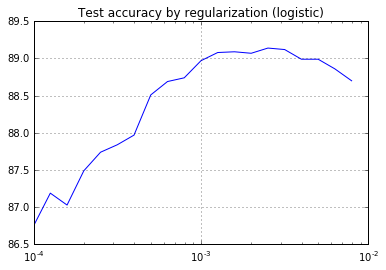

In [14]:
print(regul_val)
print(accuracy_val)
plt.semilogx(regul_val, accuracy_val)
plt.grid(True)
plt.title('Test accuracy by regularization (logistic)')
plt.show()

In [11]:
batch_size = 128
num_hidden_nodes = 1024

graph = tf.Graph()
with graph.as_default():

  # Input data. For the training data, we use a placeholder that will be fed
  # at run time with a training minibatch.
  tf_train_dataset = tf.placeholder(tf.float32,
                                    shape=(batch_size, image_size * image_size))
  tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
  tf_valid_dataset = tf.constant(valid_dataset)
  tf_test_dataset = tf.constant(test_dataset)
  beta_regul = tf.placeholder(tf.float32)
  
  # Variables.
  weights1 = tf.Variable(
    tf.truncated_normal([image_size * image_size, num_hidden_nodes]))
  biases1 = tf.Variable(tf.zeros([num_hidden_nodes]))
  weights2 = tf.Variable(
    tf.truncated_normal([num_hidden_nodes, num_labels]))
  biases2 = tf.Variable(tf.zeros([num_labels]))
  
  # Training computation.
  lay1_train = tf.nn.relu(tf.matmul(tf_train_dataset, weights1) + biases1)
  logits = tf.matmul(lay1_train, weights2) + biases2
  loss = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits(logits, tf_train_labels)) + \
      beta_regul * (tf.nn.l2_loss(weights1) + tf.nn.l2_loss(weights2))
  
  # Optimizer.
  optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(loss)
  
  # Predictions for the training, validation, and test data.
  train_prediction = tf.nn.softmax(logits)
  lay1_valid = tf.nn.relu(tf.matmul(tf_valid_dataset, weights1) + biases1)
  valid_prediction = tf.nn.softmax(tf.matmul(lay1_valid, weights2) + biases2)
  lay1_test = tf.nn.relu(tf.matmul(tf_test_dataset, weights1) + biases1)
  test_prediction = tf.nn.softmax(tf.matmul(lay1_test, weights2) + biases2)

In [12]:
num_steps = 3001

with tf.Session(graph=graph) as session:
  tf.initialize_all_variables().run()
  print("Initialized")
  for step in range(num_steps):
    # Pick an offset within the training data, which has been randomized.
    # Note: we could use better randomization across epochs.
    offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
    # Generate a minibatch.
    batch_data = train_dataset[offset:(offset + batch_size), :]
    batch_labels = train_labels[offset:(offset + batch_size), :]
    # Prepare a dictionary telling the session where to feed the minibatch.
    # The key of the dictionary is the placeholder node of the graph to be fed,
    # and the value is the numpy array to feed to it.
    feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels, beta_regul : 1e-3}
    _, l, predictions = session.run(
      [optimizer, loss, train_prediction], feed_dict=feed_dict)
    if (step % 500 == 0):
      print("Minibatch loss at step %d: %f" % (step, l))
      print("Minibatch accuracy: %.1f%%" % accuracy(predictions, batch_labels))
      print("Validation accuracy: %.1f%%" % accuracy(
        valid_prediction.eval(), valid_labels))
  print("Test accuracy: %.1f%%" % accuracy(test_prediction.eval(), test_labels))

Initialized
Minibatch loss at step 0: 613.058350
Minibatch accuracy: 7.0%
Validation accuracy: 21.5%
Minibatch loss at step 500: 201.520279
Minibatch accuracy: 85.2%
Validation accuracy: 78.7%
Minibatch loss at step 1000: 114.807167
Minibatch accuracy: 85.9%
Validation accuracy: 82.2%
Minibatch loss at step 1500: 68.538002
Minibatch accuracy: 88.3%
Validation accuracy: 83.2%
Minibatch loss at step 2000: 41.174950
Minibatch accuracy: 90.6%
Validation accuracy: 84.9%
Minibatch loss at step 2500: 25.107840
Minibatch accuracy: 89.1%
Validation accuracy: 85.7%
Minibatch loss at step 3000: 15.446046
Minibatch accuracy: 87.5%
Validation accuracy: 86.4%
Test accuracy: 92.8%


In [16]:
num_steps = 3001
regul_val = [pow(10, i) for i in np.arange(-4, -2, 0.1)]
accuracy_val = []

for regul in regul_val:    
  with tf.Session(graph=graph) as session:
    tf.initialize_all_variables().run()
    for step in range(num_steps):
      # Pick an offset within the training data, which has been randomized.
      # Note: we could use better randomization across epochs.
      offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
      # Generate a minibatch.
      batch_data = train_dataset[offset:(offset + batch_size), :]
      batch_labels = train_labels[offset:(offset + batch_size), :]
      # Prepare a dictionary telling the session where to feed the minibatch.
      # The key of the dictionary is the placeholder node of the graph to be fed,
      # and the value is the numpy array to feed to it.
      feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels, beta_regul : regul}
      _, l, predictions = session.run(
        [optimizer, loss, train_prediction], feed_dict=feed_dict)
    accuracy_val.append(accuracy(test_prediction.eval(), test_labels))

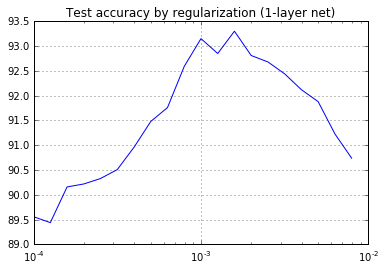

In [17]:
plt.semilogx(regul_val, accuracy_val)
plt.grid(True)
plt.title('Test accuracy by regularization (1-layer net)')
plt.show()

---
Problem 2
---------
Let's demonstrate an extreme case of overfitting. Restrict your training data to just a few batches. What happens?

---

In [18]:
batch_size = 128
num_hidden_nodes = 1024

graph = tf.Graph()
with graph.as_default():

  # Input data. For the training data, we use a placeholder that will be fed
  # at run time with a training minibatch.
  tf_train_dataset = tf.placeholder(tf.float32,
                                    shape=(batch_size, image_size * image_size))
  tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
  tf_valid_dataset = tf.constant(valid_dataset)
  tf_test_dataset = tf.constant(test_dataset)
  beta_regul = tf.placeholder(tf.float32)
  
  # Variables.
  weights1 = tf.Variable(
    tf.truncated_normal([image_size * image_size, num_hidden_nodes]))
  biases1 = tf.Variable(tf.zeros([num_hidden_nodes]))
  weights2 = tf.Variable(
    tf.truncated_normal([num_hidden_nodes, num_labels]))
  biases2 = tf.Variable(tf.zeros([num_labels]))
  
  # Training computation.
  lay1_train = tf.nn.relu(tf.matmul(tf_train_dataset, weights1) + biases1)
  logits = tf.matmul(lay1_train, weights2) + biases2
  loss = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits(logits, tf_train_labels))
  
  # Optimizer.
  optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(loss)
  
  # Predictions for the training, validation, and test data.
  train_prediction = tf.nn.softmax(logits)
  lay1_valid = tf.nn.relu(tf.matmul(tf_valid_dataset, weights1) + biases1)
  valid_prediction = tf.nn.softmax(tf.matmul(lay1_valid, weights2) + biases2)
  lay1_test = tf.nn.relu(tf.matmul(tf_test_dataset, weights1) + biases1)
  test_prediction = tf.nn.softmax(tf.matmul(lay1_test, weights2) + biases2)

In [19]:
num_steps = 101
num_bacthes = 3

with tf.Session(graph=graph) as session:
  tf.initialize_all_variables().run()
  print("Initialized")
  for step in range(num_steps):
    # Pick an offset within the training data, which has been randomized.
    # Note: we could use better randomization across epochs.
    #offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
    offset = step % num_bacthes
    # Generate a minibatch.
    batch_data = train_dataset[offset:(offset + batch_size), :]
    batch_labels = train_labels[offset:(offset + batch_size), :]
    # Prepare a dictionary telling the session where to feed the minibatch.
    # The key of the dictionary is the placeholder node of the graph to be fed,
    # and the value is the numpy array to feed to it.
    feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels, beta_regul : 1e-3}
    _, l, predictions = session.run(
      [optimizer, loss, train_prediction], feed_dict=feed_dict)
    if (step % 2 == 0):
      print("Minibatch loss at step %d: %f" % (step, l))
      print("Minibatch accuracy: %.1f%%" % accuracy(predictions, batch_labels))
      print("Validation accuracy: %.1f%%" % accuracy(
        valid_prediction.eval(), valid_labels))
  print("Test accuracy: %.1f%%" % accuracy(test_prediction.eval(), test_labels))

Initialized
Minibatch loss at step 0: 350.188141
Minibatch accuracy: 15.6%
Validation accuracy: 24.3%
Minibatch loss at step 2: 1252.904297
Minibatch accuracy: 44.5%
Validation accuracy: 37.4%
Minibatch loss at step 4: 94.086365
Minibatch accuracy: 79.7%
Validation accuracy: 57.6%
Minibatch loss at step 6: 52.897430
Minibatch accuracy: 89.1%
Validation accuracy: 56.4%
Minibatch loss at step 8: 18.736593
Minibatch accuracy: 95.3%
Validation accuracy: 65.1%
Minibatch loss at step 10: 0.000000
Minibatch accuracy: 100.0%
Validation accuracy: 64.5%
Minibatch loss at step 12: 0.000000
Minibatch accuracy: 100.0%
Validation accuracy: 64.5%
Minibatch loss at step 14: 0.000000
Minibatch accuracy: 100.0%
Validation accuracy: 64.5%
Minibatch loss at step 16: 0.000000
Minibatch accuracy: 100.0%
Validation accuracy: 64.5%
Minibatch loss at step 18: 0.000000
Minibatch accuracy: 100.0%
Validation accuracy: 64.5%
Minibatch loss at step 20: 0.000000
Minibatch accuracy: 100.0%
Validation accuracy: 64.5%


---
Problem 3
---------
Introduce Dropout on the hidden layer of the neural network. Remember: Dropout should only be introduced during training, not evaluation, otherwise your evaluation results would be stochastic as well. TensorFlow provides `nn.dropout()` for that, but you have to make sure it's only inserted during training.

What happens to our extreme overfitting case?

---

In [20]:
batch_size = 128
num_hidden_nodes = 1024

graph = tf.Graph()
with graph.as_default():

  # Input data. For the training data, we use a placeholder that will be fed
  # at run time with a training minibatch.
  tf_train_dataset = tf.placeholder(tf.float32,
                                    shape=(batch_size, image_size * image_size))
  tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
  tf_valid_dataset = tf.constant(valid_dataset)
  tf_test_dataset = tf.constant(test_dataset)
  
  # Variables.
  weights1 = tf.Variable(
    tf.truncated_normal([image_size * image_size, num_hidden_nodes]))
  biases1 = tf.Variable(tf.zeros([num_hidden_nodes]))
  weights2 = tf.Variable(
    tf.truncated_normal([num_hidden_nodes, num_labels]))
  biases2 = tf.Variable(tf.zeros([num_labels]))
  
  # Training computation.
  lay1_train = tf.nn.relu(tf.matmul(tf_train_dataset, weights1) + biases1)
  drop1 = tf.nn.dropout(lay1_train, 0.5)
  logits = tf.matmul(drop1, weights2) + biases2
  loss = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits(logits, tf_train_labels))
    
  # Optimizer.
  optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(loss)
  
  # Predictions for the training, validation, and test data.
  train_prediction = tf.nn.softmax(logits)
  lay1_valid = tf.nn.relu(tf.matmul(tf_valid_dataset, weights1) + biases1)
  valid_prediction = tf.nn.softmax(tf.matmul(lay1_valid, weights2) + biases2)
  lay1_test = tf.nn.relu(tf.matmul(tf_test_dataset, weights1) + biases1)
  test_prediction = tf.nn.softmax(tf.matmul(lay1_test, weights2) + biases2)

In [23]:
num_steps = 3001

with tf.Session(graph=graph) as session:
  tf.initialize_all_variables().run()
  print("Initialized")
  for step in range(num_steps):
    # Pick an offset within the training data, which has been randomized.
    # Note: we could use better randomization across epochs.
    offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
    # Generate a minibatch.
    batch_data = train_dataset[offset:(offset + batch_size), :]
    batch_labels = train_labels[offset:(offset + batch_size), :]
    # Prepare a dictionary telling the session where to feed the minibatch.
    # The key of the dictionary is the placeholder node of the graph to be fed,
    # and the value is the numpy array to feed to it.
    feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
    _, l, predictions = session.run(
      [optimizer, loss, train_prediction], feed_dict=feed_dict)
    if (step % 500 == 0):
      print("Minibatch loss at step %d: %f" % (step, l))
      print("Minibatch accuracy: %.1f%%" % accuracy(predictions, batch_labels))
      print("Validation accuracy: %.1f%%" % accuracy(
        valid_prediction.eval(), valid_labels))
  print("Test accuracy: %.1f%%" % accuracy(test_prediction.eval(), test_labels))

Initialized
Minibatch loss at step 0: 491.603790
Minibatch accuracy: 7.0%
Validation accuracy: 30.7%
Minibatch loss at step 500: 53.276978
Minibatch accuracy: 73.4%
Validation accuracy: 78.6%
Minibatch loss at step 1000: 19.241417
Minibatch accuracy: 74.2%
Validation accuracy: 80.3%
Minibatch loss at step 1500: 25.188087
Minibatch accuracy: 78.9%
Validation accuracy: 78.8%
Minibatch loss at step 2000: 5.523808
Minibatch accuracy: 78.9%
Validation accuracy: 79.0%
Minibatch loss at step 2500: 5.304582
Minibatch accuracy: 73.4%
Validation accuracy: 79.1%
Minibatch loss at step 3000: 4.969148
Minibatch accuracy: 73.4%
Validation accuracy: 80.3%
Test accuracy: 87.2%


---
Problem 4
---------

Try to get the best performance you can using a multi-layer model! The best reported test accuracy using a deep network is [97.1%](http://yaroslavvb.blogspot.com/2011/09/notmnist-dataset.html?showComment=1391023266211#c8758720086795711595).

One avenue you can explore is to add multiple layers.

Another one is to use learning rate decay:

    global_step = tf.Variable(0)  # count the number of steps taken.
    learning_rate = tf.train.exponential_decay(0.5, global_step, ...)
    optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss, global_step=global_step)
 
 ---


In [24]:
batch_size = 128
num_hidden_nodes1 = 1024
num_hidden_nodes2 = 100
beta_regul = 1e-3

graph = tf.Graph()
with graph.as_default():

  # Input data. For the training data, we use a placeholder that will be fed
  # at run time with a training minibatch.
  tf_train_dataset = tf.placeholder(tf.float32,
                                    shape=(batch_size, image_size * image_size))
  tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
  tf_valid_dataset = tf.constant(valid_dataset)
  tf_test_dataset = tf.constant(test_dataset)
  global_step = tf.Variable(0)

  # Variables.
  weights1 = tf.Variable(
    tf.truncated_normal(
        [image_size * image_size, num_hidden_nodes1],
        stddev=np.sqrt(2.0 / (image_size * image_size)))
    )
  biases1 = tf.Variable(tf.zeros([num_hidden_nodes1]))
  weights2 = tf.Variable(
    tf.truncated_normal([num_hidden_nodes1, num_hidden_nodes2], stddev=np.sqrt(2.0 / num_hidden_nodes1)))
  biases2 = tf.Variable(tf.zeros([num_hidden_nodes2]))
  weights3 = tf.Variable(
    tf.truncated_normal([num_hidden_nodes2, num_labels], stddev=np.sqrt(2.0 / num_hidden_nodes2)))
  biases3 = tf.Variable(tf.zeros([num_labels]))
  
  # Training computation.
  lay1_train = tf.nn.relu(tf.matmul(tf_train_dataset, weights1) + biases1)
  lay2_train = tf.nn.relu(tf.matmul(lay1_train, weights2) + biases2)
  logits = tf.matmul(lay2_train, weights3) + biases3
  loss = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits(logits, tf_train_labels)) + \
      beta_regul * (tf.nn.l2_loss(weights1) + tf.nn.l2_loss(weights2) + tf.nn.l2_loss(weights3))
  
  # Optimizer.
  learning_rate = tf.train.exponential_decay(0.5, global_step, 1000, 0.65, staircase=True)
  optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss, global_step=global_step)
  
  # Predictions for the training, validation, and test data.
  train_prediction = tf.nn.softmax(logits)
  lay1_valid = tf.nn.relu(tf.matmul(tf_valid_dataset, weights1) + biases1)
  lay2_valid = tf.nn.relu(tf.matmul(lay1_valid, weights2) + biases2)
  valid_prediction = tf.nn.softmax(tf.matmul(lay2_valid, weights3) + biases3)
  lay1_test = tf.nn.relu(tf.matmul(tf_test_dataset, weights1) + biases1)
  lay2_test = tf.nn.relu(tf.matmul(lay1_test, weights2) + biases2)
  test_prediction = tf.nn.softmax(tf.matmul(lay2_test, weights3) + biases3)

In [25]:
num_steps = 9001

with tf.Session(graph=graph) as session:
  tf.initialize_all_variables().run()
  print("Initialized")
  for step in range(num_steps):
    # Pick an offset within the training data, which has been randomized.
    # Note: we could use better randomization across epochs.
    offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
    # Generate a minibatch.
    batch_data = train_dataset[offset:(offset + batch_size), :]
    batch_labels = train_labels[offset:(offset + batch_size), :]
    # Prepare a dictionary telling the session where to feed the minibatch.
    # The key of the dictionary is the placeholder node of the graph to be fed,
    # and the value is the numpy array to feed to it.
    feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
    _, l, predictions = session.run(
      [optimizer, loss, train_prediction], feed_dict=feed_dict)
    if (step % 500 == 0):
      print("Minibatch loss at step %d: %f" % (step, l))
      print("Minibatch accuracy: %.1f%%" % accuracy(predictions, batch_labels))
      print("Validation accuracy: %.1f%%" % accuracy(
        valid_prediction.eval(), valid_labels))
  print("Test accuracy: %.1f%%" % accuracy(test_prediction.eval(), test_labels))

Initialized
Minibatch loss at step 0: 3.250091
Minibatch accuracy: 11.7%
Validation accuracy: 33.2%
Minibatch loss at step 500: 0.938743
Minibatch accuracy: 88.3%
Validation accuracy: 85.7%
Minibatch loss at step 1000: 0.874276
Minibatch accuracy: 84.4%
Validation accuracy: 86.5%
Minibatch loss at step 1500: 0.565160
Minibatch accuracy: 93.8%
Validation accuracy: 88.0%
Minibatch loss at step 2000: 0.537208
Minibatch accuracy: 93.8%
Validation accuracy: 88.2%
Minibatch loss at step 2500: 0.541276
Minibatch accuracy: 89.8%
Validation accuracy: 88.6%
Minibatch loss at step 3000: 0.553693
Minibatch accuracy: 88.3%
Validation accuracy: 88.5%
Minibatch loss at step 3500: 0.572518
Minibatch accuracy: 87.5%
Validation accuracy: 89.2%
Minibatch loss at step 4000: 0.456692
Minibatch accuracy: 93.0%
Validation accuracy: 89.1%
Minibatch loss at step 4500: 0.456059
Minibatch accuracy: 91.4%
Validation accuracy: 89.3%
Minibatch loss at step 5000: 0.505693
Minibatch accuracy: 89.8%
Validation accurac

In [26]:
batch_size = 128
num_hidden_nodes1 = 1024
num_hidden_nodes2 = 256
num_hidden_nodes3 = 128
keep_prob = 0.5

graph = tf.Graph()
with graph.as_default():

  # Input data. For the training data, we use a placeholder that will be fed
  # at run time with a training minibatch.
  tf_train_dataset = tf.placeholder(tf.float32,
                                    shape=(batch_size, image_size * image_size))
  tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
  tf_valid_dataset = tf.constant(valid_dataset)
  tf_test_dataset = tf.constant(test_dataset)
  global_step = tf.Variable(0)

  # Variables.
  weights1 = tf.Variable(
    tf.truncated_normal(
        [image_size * image_size, num_hidden_nodes1],
        stddev=np.sqrt(2.0 / (image_size * image_size)))
    )
  biases1 = tf.Variable(tf.zeros([num_hidden_nodes1]))
  weights2 = tf.Variable(
    tf.truncated_normal([num_hidden_nodes1, num_hidden_nodes2], stddev=np.sqrt(2.0 / num_hidden_nodes1)))
  biases2 = tf.Variable(tf.zeros([num_hidden_nodes2]))
  weights3 = tf.Variable(
    tf.truncated_normal([num_hidden_nodes2, num_hidden_nodes3], stddev=np.sqrt(2.0 / num_hidden_nodes2)))
  biases3 = tf.Variable(tf.zeros([num_hidden_nodes3]))
  weights4 = tf.Variable(
    tf.truncated_normal([num_hidden_nodes3, num_labels], stddev=np.sqrt(2.0 / num_hidden_nodes3)))
  biases4 = tf.Variable(tf.zeros([num_labels]))
  
  # Training computation.
  lay1_train = tf.nn.relu(tf.matmul(tf_train_dataset, weights1) + biases1)
  lay2_train = tf.nn.relu(tf.matmul(lay1_train, weights2) + biases2)
  lay3_train = tf.nn.relu(tf.matmul(lay2_train, weights3) + biases3)
  logits = tf.matmul(lay3_train, weights4) + biases4
  loss = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits(logits, tf_train_labels))
  
  # Optimizer.
  learning_rate = tf.train.exponential_decay(0.5, global_step, 4000, 0.65, staircase=True)
  optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss, global_step=global_step)
  
  # Predictions for the training, validation, and test data.
  train_prediction = tf.nn.softmax(logits)
  lay1_valid = tf.nn.relu(tf.matmul(tf_valid_dataset, weights1) + biases1)
  lay2_valid = tf.nn.relu(tf.matmul(lay1_valid, weights2) + biases2)
  lay3_valid = tf.nn.relu(tf.matmul(lay2_valid, weights3) + biases3)
  valid_prediction = tf.nn.softmax(tf.matmul(lay3_valid, weights4) + biases4)
  lay1_test = tf.nn.relu(tf.matmul(tf_test_dataset, weights1) + biases1)
  lay2_test = tf.nn.relu(tf.matmul(lay1_test, weights2) + biases2)
  lay3_test = tf.nn.relu(tf.matmul(lay2_test, weights3) + biases3)
  test_prediction = tf.nn.softmax(tf.matmul(lay3_test, weights4) + biases4)

In [27]:
num_steps = 18001

with tf.Session(graph=graph) as session:
  tf.initialize_all_variables().run()
  print("Initialized")
  for step in range(num_steps):
    # Pick an offset within the training data, which has been randomized.
    # Note: we could use better randomization across epochs.
    offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
    # Generate a minibatch.
    batch_data = train_dataset[offset:(offset + batch_size), :]
    batch_labels = train_labels[offset:(offset + batch_size), :]
    # Prepare a dictionary telling the session where to feed the minibatch.
    # The key of the dictionary is the placeholder node of the graph to be fed,
    # and the value is the numpy array to feed to it.
    feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
    _, l, predictions = session.run(
      [optimizer, loss, train_prediction], feed_dict=feed_dict)
    if (step % 500 == 0):
      print("Minibatch loss at step %d: %f" % (step, l))
      print("Minibatch accuracy: %.1f%%" % accuracy(predictions, batch_labels))
      print("Validation accuracy: %.1f%%" % accuracy(
        valid_prediction.eval(), valid_labels))
  print("Test accuracy: %.1f%%" % accuracy(test_prediction.eval(), test_labels))

Initialized
Minibatch loss at step 0: 2.375218
Minibatch accuracy: 7.8%
Validation accuracy: 33.5%
Minibatch loss at step 500: 0.346538
Minibatch accuracy: 88.3%
Validation accuracy: 86.3%
Minibatch loss at step 1000: 0.460770
Minibatch accuracy: 83.6%
Validation accuracy: 86.7%
Minibatch loss at step 1500: 0.288294
Minibatch accuracy: 91.4%
Validation accuracy: 87.9%
Minibatch loss at step 2000: 0.270482
Minibatch accuracy: 92.2%
Validation accuracy: 88.6%
Minibatch loss at step 2500: 0.310270
Minibatch accuracy: 90.6%
Validation accuracy: 88.5%
Minibatch loss at step 3000: 0.300727
Minibatch accuracy: 89.8%
Validation accuracy: 88.7%
Minibatch loss at step 3500: 0.359423
Minibatch accuracy: 88.3%
Validation accuracy: 89.2%
Minibatch loss at step 4000: 0.233859
Minibatch accuracy: 92.2%
Validation accuracy: 89.3%
Minibatch loss at step 4500: 0.256947
Minibatch accuracy: 90.6%
Validation accuracy: 89.8%
Minibatch loss at step 5000: 0.276864
Minibatch accuracy: 93.0%
Validation accuracy

In [9]:
batch_size = 128
num_hidden_nodes1 = 1024
num_hidden_nodes2 = 256
num_hidden_nodes3 = 128
num_hidden_nodes4 = 64
keep_prob = 0.5
beta_regul = 1e-3

graph = tf.Graph()
with graph.as_default():

  # Input data. For the training data, we use a placeholder that will be fed
  # at run time with a training minibatch.
  tf_train_dataset = tf.placeholder(tf.float32,
                                    shape=(batch_size, image_size * image_size))
  tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
  tf_valid_dataset = tf.constant(valid_dataset)
  tf_test_dataset = tf.constant(test_dataset)
  global_step = tf.Variable(0)

  # Variables.
  weights1 = tf.Variable(
    tf.truncated_normal(
        [image_size * image_size, num_hidden_nodes1],
        stddev=np.sqrt(2.0 / (image_size * image_size)))
    )
  biases1 = tf.Variable(tf.zeros([num_hidden_nodes1]))
  weights2 = tf.Variable(
    tf.truncated_normal([num_hidden_nodes1, num_hidden_nodes2], stddev=np.sqrt(2.0 / num_hidden_nodes1)))
  biases2 = tf.Variable(tf.zeros([num_hidden_nodes2]))
  weights3 = tf.Variable(
    tf.truncated_normal([num_hidden_nodes2, num_hidden_nodes3], stddev=np.sqrt(2.0 / num_hidden_nodes2)))
  biases3 = tf.Variable(tf.zeros([num_hidden_nodes3]))
  weights4 = tf.Variable(
    tf.truncated_normal([num_hidden_nodes3, num_hidden_nodes4], stddev=np.sqrt(2.0 / num_hidden_nodes3)))
  biases4 = tf.Variable(tf.zeros([num_hidden_nodes4]))
  weights5 = tf.Variable(
    tf.truncated_normal([num_hidden_nodes4, num_labels], stddev=np.sqrt(2.0 / num_hidden_nodes4)))
  biases5 = tf.Variable(tf.zeros([num_labels]))
    
  
  # Training computation.
  lay1_train = tf.nn.relu(tf.matmul(tf_train_dataset, weights1) + biases1)
  lay2_train = tf.nn.relu(tf.matmul(lay1_train, weights2) + biases2)
  lay3_train = tf.nn.relu(tf.matmul(lay2_train, weights3) + biases3)
  lay4_train = tf.nn.relu(tf.matmul(lay3_train, weights4) + biases4)
  logits = tf.matmul(lay4_train, weights5) + biases5
  loss = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits(logits, tf_train_labels)) + beta_regul * (tf.nn.l2_loss(weights1) + tf.nn.l2_loss(weights2) + tf.nn.l2_loss(weights3) + tf.nn.l2_loss(weights4) + tf.nn.l2_loss(weights5))
  
  # Optimizer.
  learning_rate = tf.train.exponential_decay(0.5, global_step, 4000, 0.65, staircase=True)
  optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss, global_step=global_step)
  
  # Predictions for the training, validation, and test data.
  train_prediction = tf.nn.softmax(logits)
  lay1_valid = tf.nn.relu(tf.matmul(tf_valid_dataset, weights1) + biases1)
  lay2_valid = tf.nn.relu(tf.matmul(lay1_valid, weights2) + biases2)
  lay3_valid = tf.nn.relu(tf.matmul(lay2_valid, weights3) + biases3)
  lay4_valid = tf.nn.relu(tf.matmul(lay3_valid, weights4) + biases4)
  valid_prediction = tf.nn.softmax(tf.matmul(lay4_valid, weights5) + biases5)
  lay1_test = tf.nn.relu(tf.matmul(tf_test_dataset, weights1) + biases1)
  lay2_test = tf.nn.relu(tf.matmul(lay1_test, weights2) + biases2)
  lay3_test = tf.nn.relu(tf.matmul(lay2_test, weights3) + biases3)
  lay4_test = tf.nn.relu(tf.matmul(lay3_test, weights4) + biases4)
  test_prediction = tf.nn.softmax(tf.matmul(lay4_test, weights5) + biases5)

In [10]:
num_steps = 18001

with tf.Session(graph=graph) as session:
  tf.initialize_all_variables().run()
  print("Initialized")
  for step in range(num_steps):
    # Pick an offset within the training data, which has been randomized.
    # Note: we could use better randomization across epochs.
    offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
    # Generate a minibatch.
    batch_data = train_dataset[offset:(offset + batch_size), :]
    batch_labels = train_labels[offset:(offset + batch_size), :]
    # Prepare a dictionary telling the session where to feed the minibatch.
    # The key of the dictionary is the placeholder node of the graph to be fed,
    # and the value is the numpy array to feed to it.
    feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
    _, l, predictions = session.run(
      [optimizer, loss, train_prediction], feed_dict=feed_dict)
    if (step % 500 == 0):
      print("Minibatch loss at step %d: %f" % (step, l))
      print("Minibatch accuracy: %.1f%%" % accuracy(predictions, batch_labels))
      print("Validation accuracy: %.1f%%" % accuracy(
        valid_prediction.eval(), valid_labels))
  print("Test accuracy: %.1f%%" % accuracy(test_prediction.eval(), test_labels))

Initialized
Minibatch loss at step 0: 3.534200
Minibatch accuracy: 8.6%
Validation accuracy: 22.4%
Minibatch loss at step 500: 1.114362
Minibatch accuracy: 89.1%
Validation accuracy: 85.2%
Minibatch loss at step 1000: 0.970417
Minibatch accuracy: 85.2%
Validation accuracy: 86.1%
Minibatch loss at step 1500: 0.647604
Minibatch accuracy: 89.8%
Validation accuracy: 87.3%
Minibatch loss at step 2000: 0.577514
Minibatch accuracy: 92.2%
Validation accuracy: 87.5%
Minibatch loss at step 2500: 0.554145
Minibatch accuracy: 89.1%
Validation accuracy: 87.8%
Minibatch loss at step 3000: 0.578171
Minibatch accuracy: 86.7%
Validation accuracy: 87.7%
Minibatch loss at step 3500: 0.559060
Minibatch accuracy: 86.7%
Validation accuracy: 87.8%
Minibatch loss at step 4000: 0.466781
Minibatch accuracy: 92.2%
Validation accuracy: 88.3%
Minibatch loss at step 4500: 0.435461
Minibatch accuracy: 89.1%
Validation accuracy: 88.6%
Minibatch loss at step 5000: 0.501271
Minibatch accuracy: 89.8%
Validation accuracy